In [1]:
import sys
import os
sys.path.append('../..')
sys.path

['/opt/anaconda/envs/diffLIME/lib/python39.zip',
 '/opt/anaconda/envs/diffLIME/lib/python3.9',
 '/opt/anaconda/envs/diffLIME/lib/python3.9/lib-dynload',
 '',
 '/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages',
 '/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/setuptools/_vendor',
 '../..']

In [141]:
import tensorflow as tf
from phmd import datasets
import numpy as np
from phm_framework.data import meta
from phm_framework.nets.dpm  import DiffusionModel
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.cluster import KMeans
from tslearn.metrics import dtw
from scipy.signal import correlate
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from phm_framework.nets import dpm 
from phm_framework.data import prepare_data
from phm_framework.data import synthetic
from tqdm import tqdm

In [13]:
meta_att = [f"att{i}" for i in range(10)]

dpm_model = dpm.DiffusionModel(128,
                     widths=[32, 64, 64, 32, 32, 32],
                     block_depth=3,
                     num_features=len(meta_att),
                     timesteps=20,
                     cond=True,
                     envelopes=True,
                     feature_names=meta_att,
                     feature_loss_net=False,
                     feature_loss=False)

dpm_model.network = tf.keras.models.load_model("../../../weights/CWRU_DPM_v1.h5",
                                         custom_objects = {"Gather": dpm.Gather,
                                                           "Swish": dpm.Swish})

In [4]:
ds = datasets.Dataset("CWRU")
task = ds['fault']
sets = task[0]


X_train, M_train, Y_train = prepare_data(sets['train'], 'DE', subsignal_length=128, signal_max_length=20000)
_mmin, _mmax = M_train.min(axis=0), M_train.max(axis=0)


X_val, M_val, Y_val = prepare_data(sets['val'], 'DE', subsignal_length=128, signal_max_length=20000)


Dataset CWRU already downloaded and extracted
Remember to cite the original publisher dataset:
	@misc{caseBearingData,
		author = {},
		title = {{B}earing {D}ata {C}enter | {C}ase {S}chool of {E}ngineering | {C}ase {W}estern {R}eserve {U}niversity --- engineering.case.edu},
		howpublished = {\url{https://engineering.case.edu/bearingdatacenter}},
		year = {},
		note = {[Accessed 08-04-2024]},
	}
You can download the dataset manually from:  https://engineering.case.edu/bearingdatacenter

** If you find this tool useful, please cite our SoftwareX paper.



Reading data: 100%|██████████| 161/161 [00:02<00:00, 58.87it/s] 
INFO:root:Read in 5.088100433349609 seconds
INFO:root:It is possible stratified split? True
/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: DE,unit,fault
INFO:root:Train shape: (28567988, 3)
INFO:root:Val shape: (7804030, 3)
INFO:root:Test shape: (979629, 3)
INFO:root:Meta-attributes extracted in 22.46406888961792 seconds
INFO:root:Meta-attributes extracted in 5.980592489242554 seconds


In [5]:
(X, E, M), (centroids, stds, kmeans) = synthetic.generate_synth_data(X_train, N=100000)    

/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/opt/anaconda/envs/diffLIME/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [909]:
dist = synthetic.generate_distributions(X_train, centroids, top_n=4) 

In [910]:
dist

[[{'N': 19500, 'frec_dist': (0.17149358974358975, 0.10414501261615397)},
  {'N': 4379, 'frec_dist': (0.09304171899977164, 0.07942626754430789)},
  {'N': 1392, 'frec_dist': (0.08819369612068965, 0.07967765705632891)},
  {'N': 373,
   'frec_dist': (0.0646154490616622, 0.05724386398989313),
   'slope_dist': (-4.322897578192856e-05, 0.0011847232204400399),
   'noise_dist': (13.276727227410806, 1.4801640185751614),
   'env_probs': array([0.09406421, 0.09779858, 0.09237665, 0.10335747, 0.08384074,
          0.11248711, 0.09703589, 0.09530239, 0.11972102, 0.10401595])}],
 [{'N': 19500, 'frec_dist': (0.17149358974358975, 0.10414501261615397)},
  {'N': 4379, 'frec_dist': (0.09304171899977164, 0.07942626754430789)},
  {'N': 1392, 'frec_dist': (0.08819369612068965, 0.07967765705632891)},
  {'N': 675,
   'frec_dist': (0.06055555555555556, 0.0607407098647731),
   'slope_dist': (4.85312251673929e-07, 0.0010673503450351223),
   'noise_dist': (13.12088335695489, 1.4951365691681942),
   'env_probs': ar

I0000 00:00:1734872740.716245   30900 cuda_dnn.cc:529] Loaded cuDNN version 90300


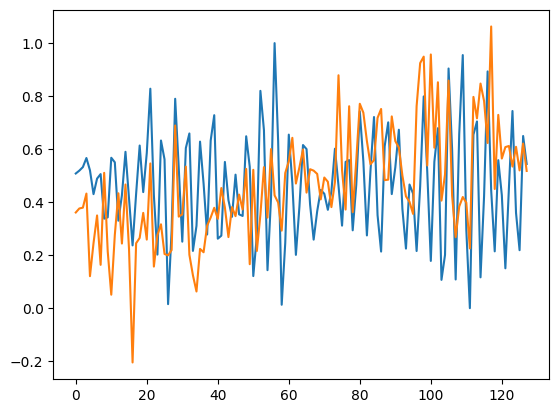

In [6]:
s = X_train[100]
f = synthetic.generate_meta(s, centroids)

f[-5] = 0.02

sn = synthetic.generate_synthetic_from_dpm(s, model, centroids, forced_features=f)


plt.plot(s)
plt.plot(sn)

In [14]:
from phm_framework.nets import cnn
from importlib import reload
reload(cnn)

nclasses = len(np.unique(Y_train))
EPOCHS = 200

results, cwru_model = cnn.train((np.expand_dims(X_train, axis=-1), Y_train), 
                           nclasses, 
                           EPOCHS, 
                           es=False, 
                           validation_data=(np.expand_dims(X_val, axis=-1), Y_val))


Epoch 1/3
153/153 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.4581 - loss: 1.3006 - val_accuracy: 0.4688 - val_loss: 1.1634
Epoch 2/3
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4758 - loss: 1.1375 - val_accuracy: 0.4688 - val_loss: 1.1505
Epoch 3/3
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4751 - loss: 1.1317 - val_accuracy: 0.4688 - val_loss: 1.1248
Epoch 1/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4834 - loss: 1.0860 - val_accuracy: 0.4936 - val_loss: 1.0722
Epoch 2/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5019 - loss: 1.0114 - val_accuracy: 0.4822 - val_loss: 1.0500
Epoch 3/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5263 - loss: 0.9639 - val_accuracy: 0.5355 - val_loss: 0.9394
Epoch 4/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5598 - loss: 0.9123 - val_accuracy: 0.5677 - val_loss: 0.9128
Epoch 5/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5744 - loss: 0.8991 - val_ac

Epoch 48/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7760 - loss: 0.5114 - val_accuracy: 0.6645 - val_loss: 0.7656
Epoch 49/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7803 - loss: 0.5104 - val_accuracy: 0.6609 - val_loss: 0.7882
Epoch 50/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7820 - loss: 0.5021 - val_accuracy: 0.6853 - val_loss: 0.7332
Epoch 51/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7915 - loss: 0.4927 - val_accuracy: 0.6935 - val_loss: 0.7217
Epoch 52/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7883 - loss: 0.4999 - val_accuracy: 0.6863 - val_loss: 0.7212
Epoch 53/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7949 - loss: 0.4814 - val_accuracy: 0.6757 - val_loss: 0.7684
Epoch 54/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7869 - loss: 0.4916 - val_accuracy: 0.6617 - val_loss: 0.7828
Epoch 55/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7937 - loss: 0

153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9525 - loss: 0.1268 - val_accuracy: 0.6847 - val_loss: 1.5085
Epoch 147/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9497 - loss: 0.1328 - val_accuracy: 0.6793 - val_loss: 1.4712
Epoch 148/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9528 - loss: 0.1263 - val_accuracy: 0.6639 - val_loss: 1.6526
Epoch 149/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9490 - loss: 0.1320 - val_accuracy: 0.6797 - val_loss: 1.5718
Epoch 150/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9551 - loss: 0.1182 - val_accuracy: 0.6783 - val_loss: 1.5991
Epoch 151/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9606 - loss: 0.1071 - val_accuracy: 0.6801 - val_loss: 1.5782
Epoch 152/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9520 - loss: 0.1289 - val_accuracy: 0.6819 - val_loss: 1.5705
Epoch 153/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9585 - loss: 0.1101 

In [18]:
cwru_model.predict(X_val[0:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


array([[2.7255660e-11, 1.0000000e+00, 2.8069254e-14, 8.6114975e-39]],
      dtype=float32)

In [1027]:
#import cv2
import numpy as np
from sklearn.linear_model import Lasso, Ridge
from scipy.spatial.distance import cosine
import matplotlib
from phm_framework.data import meta
from sklearn.preprocessing import MinMaxScaler

class DiffLIME:

    def __init__(self, model, dpm_model, envelopes, nsamples=1000, verbose=False):
        self.model = model
        self.dpm_model = dpm_model
        self.centroids = envelopes
        self.nsamples = nsamples
        self.random_state = 666
        self.verbose = verbose
        self._data = None
        self._targets = None
        self._scaler = MinMaxScaler()

    def _get_weights(self):

        def distance_fn(x):
            ref = x[0]
            distance = np.zeros((x.shape[0],))
            for i in range(x.shape[0]):
                distance[i] = cosine(x[i], ref)
                #distance[i] = np.sum((x[i] * ref)**2)
            return distance

        distances = 1 - distance_fn(self._data)
        
        distances = (distances - np.min(distances)) / (np.max(distances) - np.min(distances))
        
        sigma = 1.0
        
        #return np.exp(-distances ** 2 / (2 * sigma ** 2)) 
        return distances
    
    def __get_onehot(self, y, n):
        return [1 if i == y else 0 for i in range(n)]
    
    def prepare_data(self, signal):
        dpm_model = self.dpm_model
        centroids = self.centroids
        
        
        self._data = np.zeros((self.nsamples, signal.shape[0] + 9 + 10))
        self._targets = np.zeros((self.nsamples,))
        
        
        meta_attr = synthetic.generate_meta(signal, centroids)

        self._data[0, :signal.shape[0]] = signal
        self._data[0, signal.shape[0]:] = meta_attr[:-1] + self.__get_onehot( meta_attr[-1], len(centroids))
        
        signal = np.squeeze(signal)
        probs = cwru_model.predict(np.array([signal]), verbose=0)
        prob = probs[0, probs.argmax()]
        klass = probs.argmax()
        
        source_klass = probs.argmax()
        self._targets[0] = prob
        source_prob = prob
        
        i = 1
        while i < self.nsamples:
            sn_meta_attr = np.copy(meta_attr)
            # attribute noises
            sn_meta_attr[:9] = sn_meta_attr[:9] + np.random.uniform(-0.5, 0.5, size=(9,))
            
            # envelope noise
            sn_meta_attr[-1] = np.random.choice(list(range(10)))
            
            
            # Nota: noise_ratio=0.02 y N = 1 mejor predicción, frecuencias siempre iguales.
            sn = synthetic.generate_synthetic_from_dpm(np.copy(signal), 
                                                       dpm_model, 
                                                       centroids, 
                                                       forced_features=sn_meta_attr, 
                                                       noise_ratio=0.2, 
                                                       N=1)

            probs = cwru_model.predict(np.array([sn]), verbose=0)
            prob = probs[0, klass]
            
            
            sn_meta = synthetic.generate_meta(sn, centroids)[:-1] + self.__get_onehot(sn_meta_attr[-1], len(centroids))
            
            self._data[i, :signal.shape[0]] = sn
            self._data[i, signal.shape[0]:] = sn_meta 
            self._targets[i] = prob
            i += 1
            #print(i)
            
        self._data[:,  signal.shape[0]:] = self._scaler.fit_transform(self._data[:,  signal.shape[0]:])
            
        return source_prob, klass


    def explain(self, signal):
        
        signal_length = signal.shape[0]
        
        if self._data is None:
            source_prob, source_klass = self.prepare_data(signal)
        else:
            probs = cwru_model.predict(np.array([signal]), verbose=0)
            source_prob = probs[0, probs.argmax()]
            source_klass = probs.argmax()
        
        local_pred = None
        indexes= list(range(0, 10))
        
        smeta = synthetic.generate_meta(signal, self.centroids)
        smeta = smeta[:-1] + self.__get_onehot(smeta[-1], len(centroids))
        s = np.concatenate((signal, smeta)).reshape(1,-1)
        s[:, signal_length:] = self._scaler.transform(s[:, signal_length:])
        
        for i in range(10, self._data.shape[0]):
            idxs = indexes + [i]
            model_regressor = Ridge(alpha=1, fit_intercept=True, 
                                    random_state=self.random_state)

            weights = self._get_weights()
            model_regressor.fit(self._data[idxs], self._targets[idxs], 
                                sample_weight=weights[idxs])

            prediction_score = model_regressor.score(self._data[idxs], self._targets[idxs], 
                                                     sample_weight=weights[idxs])
            

            nlocal_pred = model_regressor.predict(s)

            if (local_pred is not None and 
                np.abs(source_prob - nlocal_pred) < np.abs(source_prob - local_pred)):
                local_pred = nlocal_pred
                indexes = idxs
            elif local_pred is None:
                local_pred = nlocal_pred
            else:
                continue
            
            if self.verbose:
                print(f'Intercept: {model_regressor.intercept_}')
                print(f'Local prediction: {local_pred}')
                print(f'Prediction score: {prediction_score}')
   

        idxs = indexes
        model_regressor = Ridge(alpha=1, fit_intercept=True, 
                                random_state=self.random_state)

        weights = self._get_weights()
        model_regressor.fit(self._data[idxs], self._targets[idxs], 
                            sample_weight=weights[idxs])

        prediction_score = model_regressor.score(self._data[idxs], self._targets[idxs], 
                                                 sample_weight=weights[idxs])

        local_pred = model_regressor.predict(s)
        
        
        #print(self._targets[idxs])
        #print(np.mean(self._targets[idxs] > 0.5))
        
        #exp = sorted(enumerate(model_regressor.coef_), key=lambda x: np.abs(x[1]), reverse=True)
        exp = model_regressor.coef_
        return (model_regressor.intercept_, exp, prediction_score, local_pred, 
                source_prob, source_klass)




In [1008]:
difflime = DiffLIME(cwru_model, dpm_model, centroids, nsamples=1000, verbose=True)
#difflime._data = _data
#difflime._targets = _targets

_, explanation, prediction_score, local_pred, source_prob, source_klass = difflime.explain(X_val[0])
prediction_score, local_pred, source_prob

Intercept: 0.5315620396883403
Local prediction: [0.83248572]
Prediction score: 0.9614176878476685
Intercept: 0.47062590702161317
Local prediction: [0.84082283]
Prediction score: 0.967601744422163
Intercept: 0.47768513817780767
Local prediction: [0.84308661]
Prediction score: 0.970418131815182
Intercept: 0.5428700315870432
Local prediction: [0.85318447]
Prediction score: 0.9745294005177658
Intercept: 0.5515344024586
Local prediction: [0.8536938]
Prediction score: 0.9756585423167904
Intercept: 0.8912777918690086
Local prediction: [0.85415573]
Prediction score: 0.95900005832901
Intercept: 0.8769620198661975
Local prediction: [0.85929724]
Prediction score: 0.95880619944747
Intercept: 0.9645208423444069
Local prediction: [0.87077239]
Prediction score: 0.9599999614619292
Intercept: 0.8659362572549747
Local prediction: [0.87252773]
Prediction score: 0.9365538248510886
Intercept: 0.8401995943033667
Local prediction: [0.8740656]
Prediction score: 0.9378778179498672
Intercept: 0.882716088161091


(0.9215811821666481, array([0.99999542]), 1.0)

/tmp/ipykernel_30900/1255447800.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  text = f"Prediction Score: {float(prediction_score):.2f}\n\nLocal Prediction: {float(local_pred):.2f}\n\nSource Probability: {float(source_prob):.2f}"
/tmp/ipykernel_30900/1255447800.py:124: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/tmp/ipykernel_30900/1255447800.py:126: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)


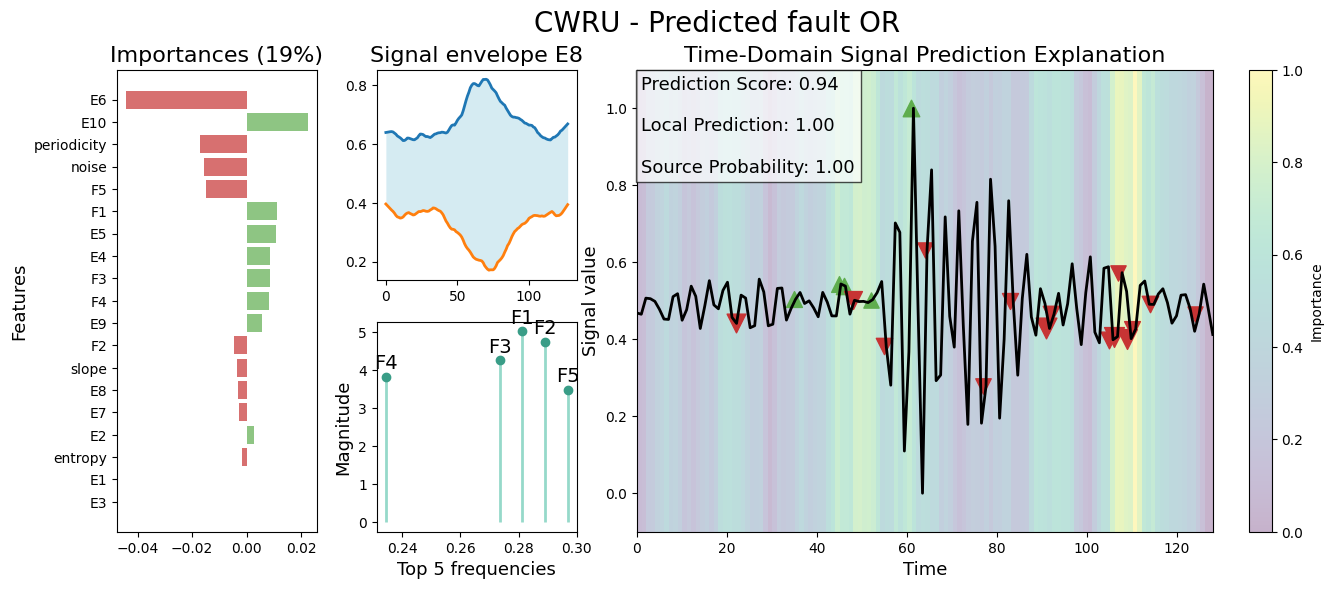

In [1028]:
    
def plot_importances(signal, point_importances, prediction_score, local_pred, 
                     source_prob, centroids, title="", topi=10):
    
    
    smeta = synthetic.generate_meta(signal, centroids)
    
    time = np.linspace(0, signal.shape[0], signal.shape[0])
    
    ini_importances = np.copy(point_importances)
    ini_importances  = ini_importances / np.abs(ini_importances).sum()
    
    point_importances = np.abs(point_importances)[:signal.shape[0]]
    
    # Función para suavizar las importancias usando una media móvil
    def smooth_importances(importancias, window_size=3):
        return np.convolve(importancias, np.ones(window_size) / window_size, mode='same')

    # Suavizar las importancias
    point_importances = smooth_importances(point_importances, window_size=10)

    # Normalizamos las importancias para que varíen entre 0 y 1
    norm_importancias = (point_importances - np.min(point_importances)) / (np.max(point_importances) - np.min(point_importances))
    
    top_arg = np.argsort(np.abs(ini_importances[:signal.shape[0]]))[-topi:]
    

    # Create the figure with subplots
    fig = plt.figure(figsize=(16, 6))  # Increase width for additional space
    ax_main = plt.subplot2grid((2, 5), (0, 2), colspan=3, rowspan=2)  # Main signal plot
    ax_freq = plt.subplot2grid((2, 5), (1, 1))             # Frequenies
    ax_env = plt.subplot2grid((2, 5), (0, 1))             # Envelope
    ax_freq_imp = plt.subplot2grid((2, 5), (0, 0), rowspan=2)             # Frequency importances plot

    
    # Usar un colormap para representar las importancias en el fondo
    cmap = matplotlib.colormaps['viridis']  # Colormap

    # Dibujar la señal en primer plano
    ax_main.plot(time, signal, label='Signal', color='black', linewidth=2)

    top_imp = ini_importances[top_arg]
    factor = 1000 if np.abs(ini_importances).max() >= 0.1 else 10000
    for x, y, s in zip(top_arg[np.where(top_imp >= 0)], 
                    signal[top_arg][np.where(top_imp >= 0)], 
                       top_imp[np.where(top_imp >= 0)]):
        ax_main.scatter(x, y, 
                    c="#5fad4eff", s=s*factor, marker="^", label="Positive Importance")
    
    
    for x, y, s in zip(top_arg[np.where(top_imp < 0)], 
                    signal[top_arg][np.where(top_imp < 0)], 
                       top_imp[np.where(top_imp < 0)]):
        ax_main.scatter(x, y, 
            c="#c73434ff", s=np.abs(s)*factor, marker="v", label="Negative Importance")
    
    # Crear un fondo de color según la importancia
    width = np.max(signal) - np.min(signal)
    im = ax_main.imshow(norm_importancias.reshape(1, -1), aspect='auto', cmap=cmap, 
               extent=[time[0], time[-1], np.min(signal) - width*0.1, np.max(signal) + width*0.1], alpha=0.3)  # Fondo con colores

    # Añadir la información al lateral izquierdo
    text = f"Prediction Score: {float(prediction_score):.2f}\n\nLocal Prediction: {float(local_pred):.2f}\n\nSource Probability: {float(source_prob):.2f}"
    ax_main.text(1, np.max(signal) + width*0.085, text, 
             fontsize=13, va='top', ha='left', 
             bbox=dict(facecolor='white', alpha=0.7))
    
    # Frecuencies plot and importances
    frec, magn = list(zip(*meta.extract_top_frequencies(signal, top_n=5)))
    for i, (freq, mag) in enumerate(zip(frec, magn)):
        ax_freq.vlines(x=freq, ymin=0, ymax=mag, colors='#96d9caff', linestyles='-', lw=2, label=f'Frequency: {freq} Hz' if mag == max(magn) else None)
        ax_freq.text(freq, mag + 0.2, f"F{i+1}", ha='center', fontsize=14, color='black')  # Add label above the line
    
    # Scatter points at the tip of the lines for clarity
    ax_freq.scatter(frec, magn, color='#399d87ff', zorder=5, label='Magnitudes')
    
    ax_freq.set_xlabel('Top 5 frequencies', fontsize=13)
    ax_freq.set_ylabel('Magnitude', fontsize=13)
    
    # Frequency importances (last 5 elements of the importance vector)
    frequency_importances = ini_importances[signal.shape[0]:signal.shape[0]+5]
    frequency_labels = [f"F{i+1}" for i in range(len(frequency_importances))]

    
    
    attributtes = (#[f"S{i}" for i in range(X.shape[1])] + 
               [f"F{i+1}" for i in range(5)] + 
               ['slope', 'noise', 'entropy', 'periodicity'] + 
               [f"E{i+1}" for i in range(len(centroids))])

    
    
    
    ini_importances = ini_importances[signal.shape[0]:]
    aux = list(zip(ini_importances, attributtes))
    frequency_importances, frequency_labels = list(zip(*sorted(aux, key=lambda x: -np.abs(x[0]))[:][::-1]))
    
    colors = ['#5fad4eff' if imp > 0 else '#c73434ff' for imp in frequency_importances]
    
    ax_freq_imp.barh(frequency_labels, frequency_importances,  color=colors, alpha=0.7)
    ax_freq_imp.set_title(f"Importances ({round(np.abs(ini_importances).sum() * 100)}%)", fontsize=16)
    ax_freq_imp.set_ylabel("Features", fontsize=13)
    #ax_freq_imp.set_xlim(-0.5, 0.5)
    
    # Etiquetas y título
    color_bar = fig.colorbar(im, ax=ax_main, label='Importance')  # Barra de color para la importancia
    ax_main.set_xlabel('Time', fontsize=13)
    ax_main.set_ylabel('Signal value', fontsize=13)
    ax_main.set_title('Time-Domain Signal Prediction Explanation', fontsize=16)
    
    # Plot envelope
    ax_env.plot(centroids[smeta[-1]][0], linewidth=2)
    ax_env.plot(centroids[smeta[-1]][1], linewidth=2)
    ax_env.fill_between(
        np.arange(len(centroids[smeta[-1]][0])),  # El eje X (puede ser el rango de los índices de los datos)
        centroids[smeta[-1]][0],  # Valores para la primera línea
        centroids[smeta[-1]][1],  # Valores para la segunda línea
        color='lightblue',        # Color del relleno
        alpha=0.5,                # Transparencia del relleno
        linewidth=0               # Opcional, para evitar líneas de borde
    )
    ax_env.set_title(f'Signal envelope E{int(smeta[-1])+1}', fontsize=16)
    
    # Mostrar la gráfica
    plt.legend(loc="upper right")
    ax_freq.legend().set_visible(False) 
    ax_freq_imp.legend().set_visible(False) 
    
    plt.subplots_adjust(hspace=0.2, wspace=0.3) 
    fig.suptitle(title, fontsize=20)
    
    
plot_importances(X_val[0], explanation, prediction_score, local_pred, 
                 source_prob, centroids, title=f"CWRU - Predicted fault {task.meta['target_labels'][source_klass]}", topi=20)
plt.savefig("imp.svg")

In [ ]:
indexes = np.arange(0, X_val.shape[0])
np.random.shuffle(indexes)

for i in indexes:
    difflime = DiffLIME(cwru_model, dpm_model, centroids, nsamples=12, verbose=False)
    (_, explanation, prediction_score, local_pred, 
     source_prob, source_klass) = difflime.explain(X_val[i])
    plot_importances(X_val[i], explanation, prediction_score, local_pred, 
                     source_prob, centroids, 
                     title=f"CWRU - Predicted fault {task.meta['target_labels'][source_klass]}", 
                     topi=20)
    plt.savefig(f"CWRU/S{i}_k{int(Y_val[i][0])}_p{source_klass}.svg")
    plt.savefig(f"CWRU/S{i}_k{int(Y_val[i][0])}_p{source_klass}.png")

/tmp/ipykernel_30900/1255447800.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  text = f"Prediction Score: {float(prediction_score):.2f}\n\nLocal Prediction: {float(local_pred):.2f}\n\nSource Probability: {float(source_prob):.2f}"
/tmp/ipykernel_30900/1255447800.py:124: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/tmp/ipykernel_30900/1255447800.py:126: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
/tmp/ipykernel_30900/1255447800.py:62: DeprecationWarning: Conversion of an array with ndim >

/tmp/ipykernel_30900/1255447800.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  text = f"Prediction Score: {float(prediction_score):.2f}\n\nLocal Prediction: {float(local_pred):.2f}\n\nSource Probability: {float(source_prob):.2f}"
/tmp/ipykernel_30900/1255447800.py:124: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
/tmp/ipykernel_30900/1255447800.py:126: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_freq_imp.legend().set_visible(False)
/tmp/ipykernel_30900/1255447800.py:62: DeprecationWarning: Conversion of an array with ndim >

In [1018]:
np.random.shuffle(np.arange(0, X_val.shape[0]))

In [1025]:
int(Y_val[i][0])

3

In [1024]:
Y_val[i]

array([3.])